In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import reader1 as rd
import utilerias as utls
from torch.utils.tensorboard import SummaryWriter
import PIL.Image
# Llamamos a la función antes de ejecutar el script
utls.eliminar_archivos_registro("logs/lstm")
from torchvision.transforms import ToTensor

In [2]:
writer = SummaryWriter('logs/lstm')
DATOS = 'Datos históricos COMI 3ene16-31dic2020 semanal.csv'
cierre = rd.leer_archivo(DATOS).astype(float)
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

#Se convierte en un arreglo bidimensional
c_entrenamiento = np.reshape(c_entrenamiento, (c_entrenamiento.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

m_m_s = MinMaxScaler(feature_range=(0,1))
c_entrenamiento_n = m_m_s.fit_transform(c_entrenamiento)

In [4]:
time_steps = 8
N = len(c_entrenamiento_n) #182
X_entrenamiento = []
y_entrenamiento = []
for i in range(time_steps, N):
    X_entrenamiento.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_entrenamiento.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1
X_entrenamiento, y_entrenamiento = np.array(X_entrenamiento), np.array(y_entrenamiento)
#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_entrenamiento = np.reshape(X_entrenamiento, (X_entrenamiento.shape[0], X_entrenamiento.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import load_model

red = load_model('models/LSTM.h5')

In [6]:
"""#Se entrena con un aprendizaje por reforzamiento del profesor
red = Sequential()
red.add(LSTM(units=50,return_sequences=True,input_shape=(X_entrenamiento.shape[1], 1)))#tiene un tamaño de entrada de 8 y de salida 1, input_shape = (8, 1)
red.add(Dropout(0.2))#Se apagan aleatoriamente el 20% de las neuronas de la capa anterior
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50))
red.add(Dropout(0.2))
red.add(Dense(units=1))
red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)
history = red.fit(X_entrenamiento,y_entrenamiento,epochs=60,batch_size=32)#batch_size=32"""

"#Se entrena con un aprendizaje por reforzamiento del profesor\nred = Sequential()\nred.add(LSTM(units=50,return_sequences=True,input_shape=(X_entrenamiento.shape[1], 1)))#tiene un tamaño de entrada de 8 y de salida 1, input_shape = (8, 1)\nred.add(Dropout(0.2))#Se apagan aleatoriamente el 20% de las neuronas de la capa anterior\nred.add(LSTM(units=50,return_sequences=True))\nred.add(Dropout(0.2))\nred.add(LSTM(units=50,return_sequences=True))\nred.add(Dropout(0.2))\nred.add(LSTM(units=50))\nred.add(Dropout(0.2))\nred.add(Dense(units=1))\nred.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)\nhistory = red.fit(X_entrenamiento,y_entrenamiento,epochs=60,batch_size=32)#batch_size=32"

In [7]:
# Obtener la pérdida durante el entrenamiento
"""losses = history.history['loss']
print(losses)
plt.plot(range(len(losses)),losses)
plt.show()"""

"losses = history.history['loss']\nprint(losses)\nplt.plot(range(len(losses)),losses)\nplt.show()"

In [8]:
precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
precios_reales = np.reshape(precios_reales, (precios_reales.shape[0], 1)) #se le da una dimension mas

In [9]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values

inputs_cierre = cierre[len(cierre) - len(precios_reales) - time_steps:]#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
#print(len(cierre) - len(precios_reales) - time_steps)
inputs_cierre = np.array(inputs_cierre).reshape(-1,1)
#print(len(inputs_cierre))
#print(inputs_cierre.shape)
m_m_s_entrenamiento = MinMaxScaler(feature_range=(0,1))
inputs_cierre = m_m_s_entrenamiento.fit_transform(inputs_cierre)# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
#inputs_cierre = m_m_s.transform(inputs_cierre) 
X_entrenamiento = []
for i in range(time_steps, len(inputs_cierre)):
    X_entrenamiento.append(inputs_cierre[i-time_steps:i, 0]) # setoman en paquetes de 8 
X_entrenamiento = np.array(X_entrenamiento)
X_entrenamiento = np.reshape(X_entrenamiento, (X_entrenamiento.shape[0], X_entrenamiento.shape[1], 1))#(78, 8, 1)

precios_predichos = red.predict(X_entrenamiento)
s_normalizar = precios_predichos
precios_predichos = m_m_s_entrenamiento.inverse_transform(precios_predichos)

3/3 [==============================] - 1s 3ms/step


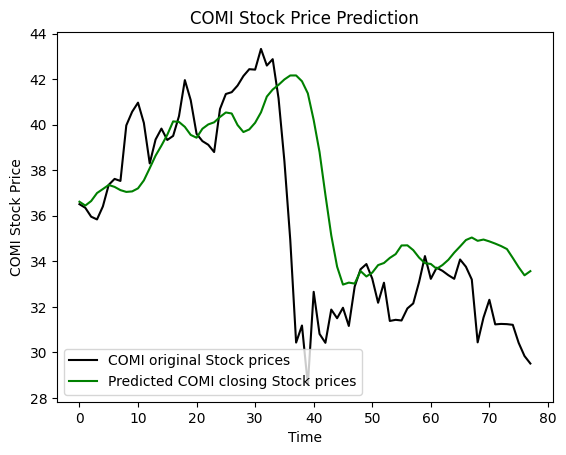

In [10]:
#La normalización funciona correctamente
plt.plot(precios_reales, color = 'black', label = 'COMI original Stock prices')
plt.plot(precios_predichos, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [11]:
# Guardar el modelo entrenado
# red.save('models/LSTM.h5')

In [12]:
# print(y_entrenamiento.size)
# plt.plot(y_entrenamiento)
# plt.show()

In [13]:
# ts_cierre_s_pred = c_entrenamiento_n

# loss_m = []
# for epoch in range(100):  # Número de épocas
#     ts_cierre_s_pred = c_entrenamiento_n[:time_steps]#se obtienen los primeros time_steps(8) elementos del trainig set
#     loss = []
#     X_train_c_pred = []
#     # print(f"grtrt: {ts_cierre_s_pred}")
#     for i in range(time_steps, N):
#         # Obtener las características y la etiqueta actual
#         x_actual = ts_cierre_s_pred[i-time_steps:i,0]
#         X_train_c_pred.append(x_actual)
#         x_actual = x_actual.reshape(1,time_steps,1)

#         y_actual = np.array([y_entrenamiento[i-time_steps]])

#         print(f"x_actual: {x_actual}")
#         print(f"y_actual: {y_actual}")
        
#         # Entrenar el modelo con las nuevas características y la etiqueta real
#         #loss.append(red.train_on_batch(x_actual, y_actual))

#         # Predicción del modelo
#         #prediccion = red.predict(x_actual)#.reshape(1,1,1)
#         prediccion = red(x_actual)
        
#         # Agregar la predicción a las características para el siguiente paso
#         # print(ts_cierre_s_pred)
#         print(f"prediccion: {prediccion}")
#         ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])



#     # print(f"mean: {np.mean(np.array(loss))}")
#     # loss_m.append(np.mean(np.array(loss)))
#     X_train_c_pred = np.array(X_train_c_pred)
#     X_train_c_pred = np.reshape(X_train_c_pred, (X_train_c_pred.shape[0], X_train_c_pred.shape[1], 1))
#     history = red.fit(X_train_c_pred, y_entrenamiento, epochs=1, batch_size=32)
#     loss = history.history['loss']
#     loss_m.append(loss)
#     loss_m.append(mean_squared_error(c_entrenamiento_n,ts_cierre_s_pred[:,0]))

In [14]:
red.compile(optimizer=SGD(learning_rate=1e-3),loss='mean_squared_error')
ts_cierre_s_pred = c_entrenamiento_n
sub_epocas = 1
t_lote = 1

loss_m = []
for epoca in range(25):  # Número de épocas
    ts_cierre_s_pred = c_entrenamiento_n[:time_steps] #:8 se toman los primeros 8 elementos del conjunto de entrenamiendo predictivo 
    loss = []
    n_ejemplar = 1
    x_lote = []
    # print(f"grtrt: {ts_cierre_s_pred}")
    for i in range(0,len(y_entrenamiento)):#time_steps+1
        print(i)
        # Obtener las características y la etiqueta actual
        ejemplar = ts_cierre_s_pred[i:i+time_steps,0]

        x_lote.append(ejemplar)

        # Predicción del modelo
        #prediccion = red.predict(x_actual)#.reshape(1,1,1)
        prediccion = red(ejemplar.reshape(1,time_steps,1))
        
        # Agregar la predicción a las características para el siguiente paso
        # print(ts_cierre_s_pred)
        #print(f"prediccion: {prediccion}")
        ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])

        if(n_ejemplar == t_lote):
            
            print(f"y: {np.array( y_entrenamiento[i-t_lote+1:i+1]).reshape(t_lote,1)}")
            print(f"x_lote: {np.array(x_lote).shape}")
            train = red.train_on_batch(np.array(x_lote), np.array( y_entrenamiento[i-t_lote+1:i+1]).reshape(t_lote,1))
            print(f"train: {train}")
            loss.append(train)#np.array(y_entrenamiento[i:i+t_lote])
            x_lote = []
            n_ejemplar = 0
            
        n_ejemplar = n_ejemplar+1
        

        # Entrenar el modelo con las nuevas características y la etiqueta real
        # for sub_epoca in range(sub_epocas):
        #     red.train_on_batch(x_actual, y_actual)
        #     if(sub_epoca == sub_epocas - 1):
        #         loss.append(red.train_on_batch(x_actual, y_actual))
        

        
    #print(f"mean: {np.mean(np.array(loss))}")
    #loss_m.append(np.mean(np.array(loss)))
    mse = np.mean(np.array(mean_squared_error(c_entrenamiento_n,ts_cierre_s_pred[:,0])))
    loss_m.append(mse)
    writer.add_scalar(f'Perdida de entrenamiento predictivo de la red: ', mse, epoca+1)
    
    
    plot_buf = utls.gen_plot(c_entrenamiento_n,ts_cierre_s_pred,mse)

    image = PIL.Image.open(plot_buf)
    image = ToTensor()(image).unsqueeze(0)
    writer.add_image(f'Comportamiento de la serie de tiempo para la red: {0} durante el entrenamiento predictivo', image, epoca+1,dataformats='NCHW')

writer.close()

0
y: [[0.04610616]]
x_lote: (1, 8)
train: 0.040727999061346054
1
y: [[0.10422317]]
x_lote: (1, 8)
train: 0.009989631362259388
2
y: [[0.1542038]]
x_lote: (1, 8)
train: 0.00293403840623796
3
y: [[0.15575358]]
x_lote: (1, 8)
train: 0.0033578025177121162
4
y: [[0.12553274]]
x_lote: (1, 8)
train: 0.008950948715209961
5
y: [[0.14567997]]
x_lote: (1, 8)
train: 0.007798872422426939
6
y: [[0.14645486]]
x_lote: (1, 8)
train: 0.022997405380010605
7
y: [[0.19604804]]
x_lote: (1, 8)
train: 0.022930150851607323
8
y: [[0.2305308]]
x_lote: (1, 8)
train: 0.0015204122755676508
9
y: [[0.20844634]]
x_lote: (1, 8)
train: 0.02683814987540245
10
y: [[0.21193336]]
x_lote: (1, 8)
train: 0.02763773687183857
11
y: [[0.207284]]
x_lote: (1, 8)
train: 0.058880992233753204
12
y: [[0.19294847]]
x_lote: (1, 8)
train: 0.025327162817120552
13
y: [[0.19682294]]
x_lote: (1, 8)
train: 0.022938061505556107
14
y: [[0.21425804]]
x_lote: (1, 8)
train: 0.0259757898747921
15
y: [[0.18132507]]
x_lote: (1, 8)
train: 0.045196913182

[0.1394543514704232, 0.12791487940595822, 0.1303781153157619, 0.12760330946721357, 0.12701777186470425, 0.12441158845268278, 0.12404686451193306, 0.12273704147931591, 0.12707977418747363, 0.1276421716715854, 0.12665773183303322, 0.12676716102553662, 0.12462786000881391, 0.12628300245431168, 0.12506218467918606, 0.12565296134664705, 0.12560728331036342, 0.12406642195942574, 0.125352100510528, 0.12657007640464865, 0.12394675984028718, 0.12536900978663598, 0.12389545566442009, 0.12163363608310492, 0.12134549179595364]


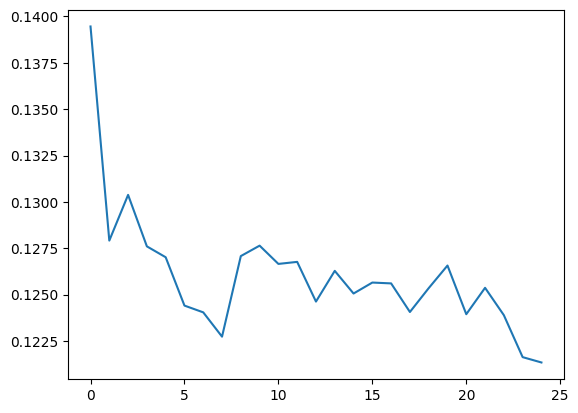

In [15]:
print(loss_m)
plt.plot(range(len(loss_m)),loss_m)
plt.show()
# losses = history.history['loss']
# print(losses)
# plt.plot(range(len(losses)),losses)
# plt.show()

In [16]:


# for i in range(time_steps, N):
#     X_entrenamiento.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
#     y_entrenamiento.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1

# Ahora, el modelo ha sido entrenado de manera iterativa

# print(X_entrenamiento.shape)
# print(X_entrenamiento[0,:].shape)
f_X_test_cierre = np.reshape(X_entrenamiento[0,:], (1, X_entrenamiento[0,:].shape[0], 1))
# print(f_X_test_cierre)
f_predicted_sp_cierre = red.predict(f_X_test_cierre)
print(f"shape: {precios_predichos.shape}")
f_predicted_sp_cierre = m_m_s.inverse_transform(f_predicted_sp_cierre)
print(f_X_test_cierre.reshape(8))

# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)

predicted_stock_price_cierre_pred = utls.genera_prediccion_predictiva(f_X_test_cierre.reshape(8),8,78,red)
print(f"shape: {predicted_stock_price_cierre_pred.shape}")
temp = predicted_stock_price_cierre_pred
predicted_stock_price_cierre_pred = m_m_s.inverse_transform(predicted_stock_price_cierre_pred.reshape(86,1))
# input_shape_primera_capa = red.layers[0].input_shape
# print(input_shape_primera_capa[1:])

# arreglo_una_dimension = np.random.rand(8)  # Completa con tus valores reales

# # Utilizar input_shape_primera_capa en la función reshape
# arreglo_reshape = arreglo_una_dimension.reshape(1, *input_shape_primera_capa[1:])
# print(arreglo_reshape)


1/1 [==============================] - 1s 1s/step
shape: (78, 1)
[0.54539295 0.44850949 0.42344173 0.48577236 0.49051491 0.56368564
 0.57520325 0.55691057]
1/1 [==============================] - 0s 16ms/step
shape: (86,)


1/1 [==============================] - 0s 16ms/step


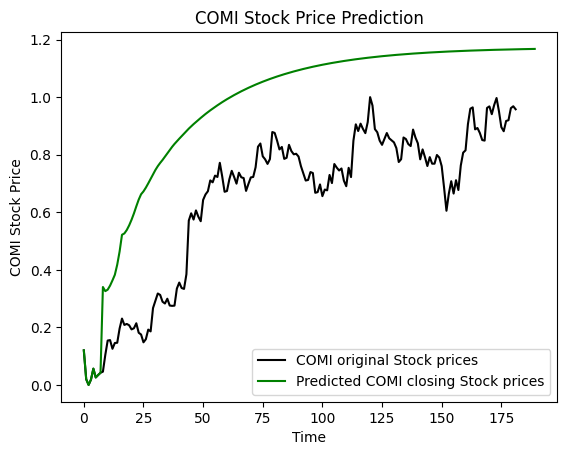

In [17]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva (usando los datos que predice)

#f_X_train_cierre = np.reshape(X_entrenamiento[0,:], (1, X_entrenamiento[0,:].shape[0], 1))
f_X_train_cierre = c_entrenamiento_n[:time_steps].reshape(8)
# # print(f_X_test_cierre)
# f_predicted_t_sp_cierre = red.predict(f_X_train_cierre)
# print(f"shape: {precios_predichos.shape}")
# f_predicted_sp_cierre = m_m_s.inverse_transform(f_predicted_t_sp_cierre)
# print(f_X_test_cierre.reshape(8))

predicted_stock_price_cierre_pred_t = utls.genera_prediccion_predictiva(f_X_train_cierre,8,182,red)
# print(f"shape: {predicted_stock_price_cierre_pred_t.shape}")
# temp_t = predicted_stock_price_cierre_pred_t
# predicted_stock_price_cierre_pred = m_m_s.inverse_transform(predicted_stock_price_cierre_pred.reshape(86,1))

#Sin normalizar
plt.plot(c_entrenamiento_n, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre_pred_t, color = 'green', label = 'Predicted COMI closing Stock prices') #ts_cierre_s_pred[:,0]
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

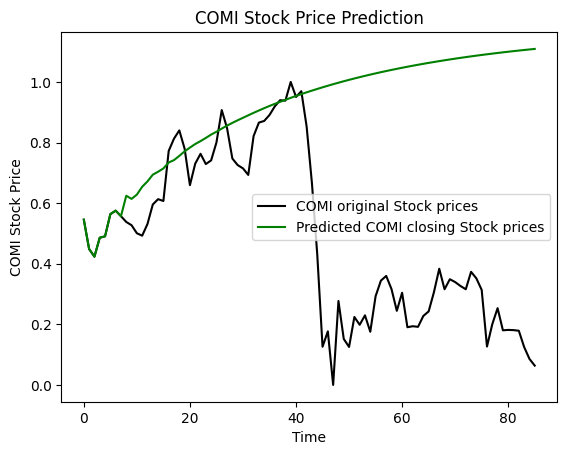

In [18]:
#Sin normalizar
plt.plot(inputs_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(temp, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [19]:
# #Sin normalizar
# plt.plot(inputs_cierre, color = 'black', label = 'COMI original Stock prices')
# plt.plot(temp, color = 'green', label = 'Predicted COMI closing Stock prices')
# plt.title('COMI Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('COMI Stock Price')
# plt.legend()
# plt.show()

In [20]:

# plt.plot(precios_reales, color = 'black', label = 'COMI original Stock prices')
# plt.plot(predicted_stock_price_cierre_pred, color = 'green', label = 'Predicted COMI closing Stock prices')
# plt.title('COMI Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('COMI Stock Price')
# plt.legend()
# plt.show()

In [21]:
import torch
import torch.nn as nn
criterion = nn.MSELoss()
perdida = criterion(torch.tensor(precios_reales),torch.tensor(precios_predichos))
print(perdida)
perdida = criterion(torch.tensor(precios_reales),torch.tensor(predicted_stock_price_cierre_pred[:78]))
print(perdida)

tensor(11.9232, dtype=torch.float64)
tensor(64.3520, dtype=torch.float64)
